## EOSC 556B: Assignment 1
Name: Parth Pokar
Student ID: 43949999

In [72]:
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Question 1 ##
\
$ v_{int} = v_0 + \alpha \sin(\omega t) + \beta t $

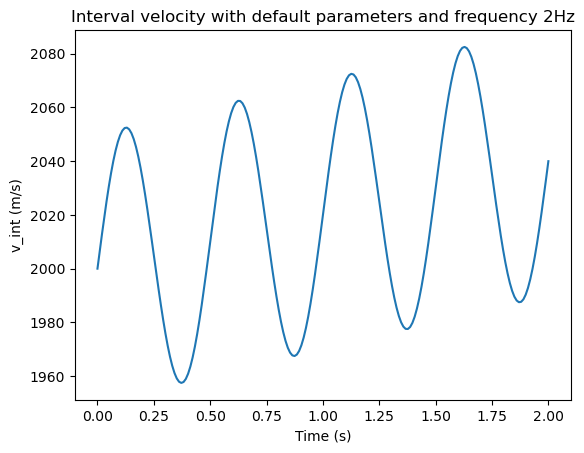

In [73]:
##part a
def get_vint(v0, alpha, beta, omega, t):
    return v0 + alpha * np.sin(omega * t) + beta * t

f = 2
t = np.linspace(0, 2, 200)
v_int = get_vint(v0=2000,alpha=50,beta=20,omega=2*np.pi*f,t=t)
plt.plot(t, v_int)
plt.xlabel('Time (s)')
plt.ylabel('v_int (m/s)')
plt.title('Interval velocity with default parameters and frequency 2Hz');

##part b

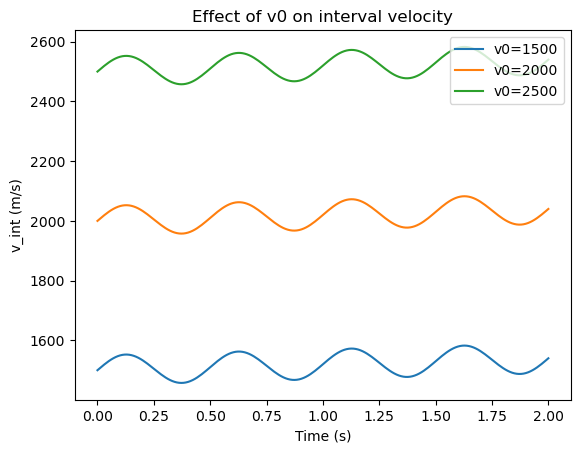

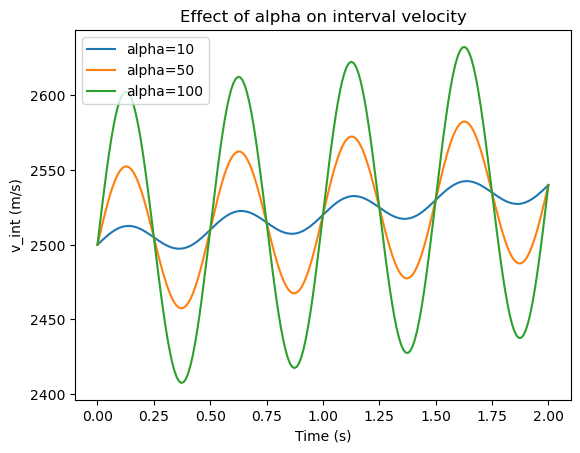

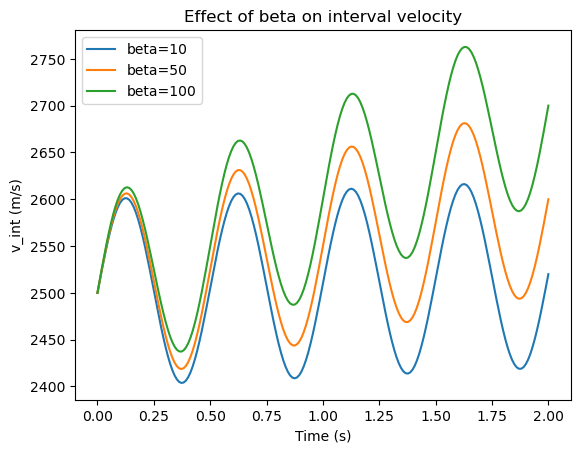

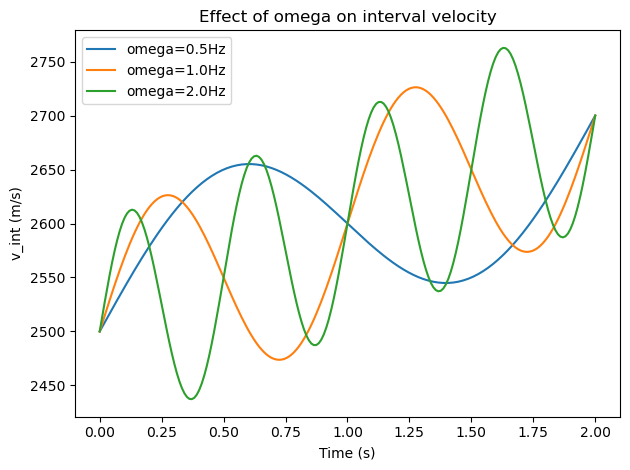

In [74]:
#Plots to show the effect of v0, alpha, beta and omega on interval velocity
# Plot for different v0
def plot_vint(v0, alpha, beta, omega, label):
    t = np.linspace(0, 2, 200)
    v_int = get_vint(v0, alpha, beta, omega, t)
    plt.plot(t, v_int, label=label)

#default parameters
v0 = 2000
alpha = 50
beta = 20
omega = 2*np.pi*f

for v0 in [1500, 2000, 2500]:
    plot_vint(v0, alpha, beta, omega, f'v0={v0}')
plt.xlabel('Time (s)')
plt.ylabel('v_int (m/s)')
plt.title('Effect of v0 on interval velocity')
plt.legend()
plt.show()

# Plot for different alpha
for alpha in [10, 50, 100]:
    plot_vint(v0, alpha, beta, omega, f'alpha={alpha}')
plt.xlabel('Time (s)')
plt.ylabel('v_int (m/s)')
plt.title('Effect of alpha on interval velocity')
plt.legend()
plt.show()

# Plot for different beta
for beta in [10, 50, 100]:
    plot_vint(v0, alpha, beta, omega, f'beta={beta}')
plt.xlabel('Time (s)')
plt.ylabel('v_int (m/s)')
plt.title('Effect of beta on interval velocity')
plt.legend()
plt.show()

# Plot for different omega
for omega in [2*np.pi*0.5, 2*np.pi*1, 2*np.pi*2]:
    plot_vint(v0, alpha, beta, omega, f'omega={omega/(2*np.pi)}Hz')
plt.xlabel('Time (s)')
plt.ylabel('v_int (m/s)')
plt.title('Effect of omega on interval velocity')
plt.legend()
plt.tight_layout()

(c)\
$V^2_{rms} (t_j) = \frac{1}{t_j} \int_{0}^{t_{max}} v^2_{int}(u) du$

Computing the analytic solution for $v_{rms}$ using Wolfram Alpha, we get:
$$ v_{rms}^2 (t) = \left(\frac{1}{t}\right) \left(\frac{1}{6\omega^2}\right) \left((\omega^2 t) \left(3\alpha^2+2\beta^2t^2+6v_0\beta t+6v_0^2\right)+ 12\alpha\beta\sin(\omega t)- \\
\left(3\alpha\omega\cos(\omega t)\right) \left(\alpha\sin(\omega t)+4\left(v_0+\beta t\right)\right) + 12v_0\alpha\omega)\right) $$

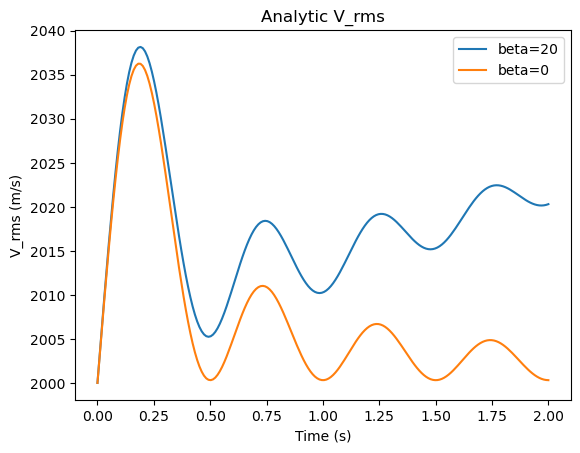

In [75]:
#putting the above expression in the code
def get_vrms(v0, alpha, beta, omega, t):
    inds_nonzero = t > 0 # in general a small number

    vrms = np.zeros_like(t)  # np.zeros(len(t))

    vrms[inds_nonzero] = np.sqrt((1/t[inds_nonzero])*
        (1/(6*omega**2))*((t[inds_nonzero]*omega**2)* (3*alpha**2+2*beta**2*t[inds_nonzero]**2+6*v0*beta*t[inds_nonzero]+6*v0**2)+
 12*alpha*beta*np.sin(t[inds_nonzero]*omega)-
 ((3*alpha*omega*np.cos(t[inds_nonzero]*omega))*
 (alpha*np.sin(t[inds_nonzero]*omega)+4*(v0+t[inds_nonzero]*beta))) + 12*v0*alpha*omega)
        )
    vrms[~inds_nonzero] = v0
    return vrms

v0 = 2000
alpha = 50
beta = 20
omega = 2*np.pi*f
beta_0 = 0

vrms_analytic = get_vrms(v0, alpha, beta, omega, t)
vrms_analytic_beta = get_vrms(v0, alpha, beta_0, omega, t)
plt.plot(t, vrms_analytic, label='beta=20')
plt.plot(t, vrms_analytic_beta, label='beta=0')
plt.xlabel('Time (s)')
plt.ylabel('V_rms (m/s)')
plt.title('Analytic V_rms');
plt.legend()

Analytic inverse of v_int from vrms is given by:

$$v_{int}(t) = V_{rms}(t) \left(1 + \frac{2tV'_{rms}(t)}{V_{rms}(t)}\right)^{\frac{1}{2}} $$

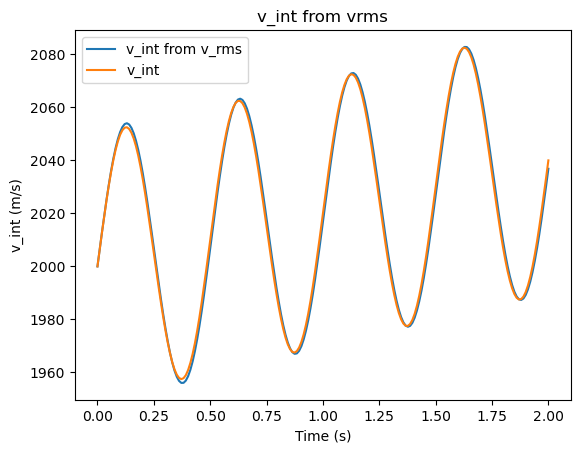

In [76]:
## part d
# Create function to estimate v_int from vrms which takes time and vrms.
# We will use finite difference to compute derivative of vrms to get v_int
def get_vint_from_vrms(vrms, t):
    dt = np.diff(t)
    dv = np.diff(vrms)
    dv_dt = dv / dt
    dv_dt = np.r_[0, dv_dt]
    return vrms * (1 + (2*t*dv_dt)/vrms)**0.5

vint_from_vrms = get_vint_from_vrms(vrms_analytic, t)
plt.plot(t, vint_from_vrms, label='v_int from v_rms')
plt.plot(t, v_int, label='v_int')
plt.xlabel('Time (s)')
plt.ylabel('v_int (m/s)')
plt.title('v_int from vrms')
plt.legend();


## Question 2 ##

Downsample data

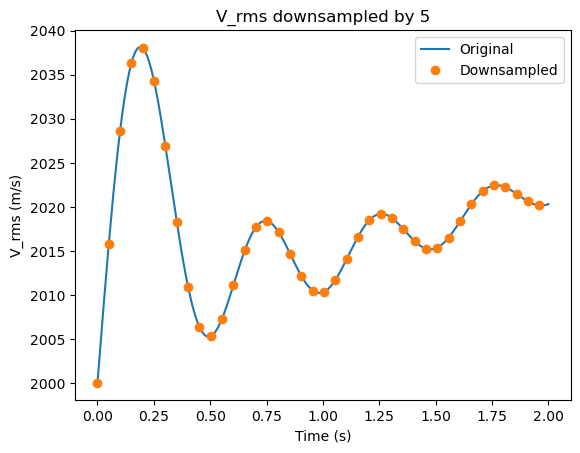

In [77]:
##Downsample v_int data above by factor of 5
t_down = t[::5]
##Effect of downsampling on v_rms
vrms_analytic_down = get_vrms(v0, alpha, beta, omega, t_down)
plt.plot(t, vrms_analytic, label='Original')
plt.plot(t_down, vrms_analytic_down, 'o', label='Downsampled')
plt.xlabel('Time (s)')
plt.ylabel('V_rms (m/s)')
plt.title('V_rms downsampled by 5')
plt.legend();


Part 2b

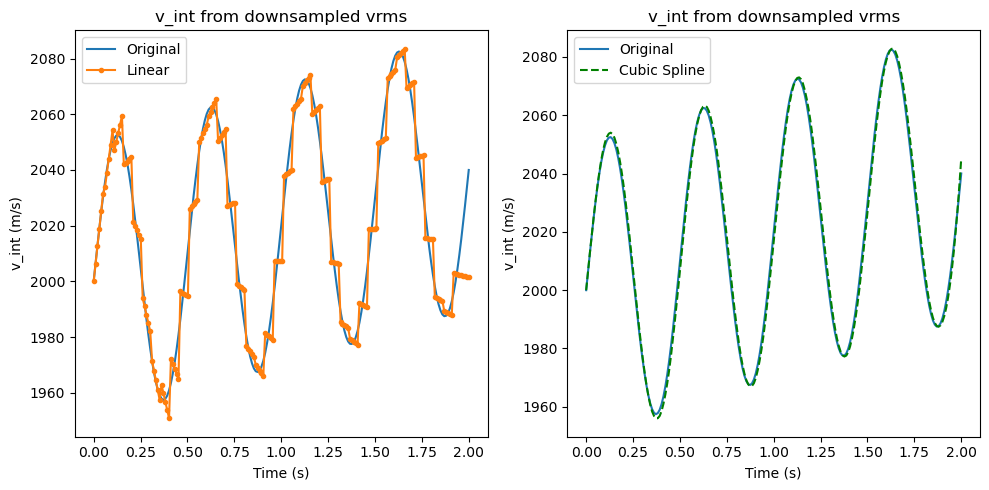

In [78]:

##Interpolate the downsampled data using linear and cubic spline interpolation

linear_interpolation = interp1d(t_down, vrms_analytic_down, kind="linear", fill_value="extrapolate")
spline_interpolation = interp1d(t_down, vrms_analytic_down, kind="cubic", fill_value="extrapolate")

vrms_down_linear = linear_interpolation(t)
vrms_down_spline = spline_interpolation(t)
vint_from_vrms_linear = get_vint_from_vrms(vrms_down_linear, t)
vint_from_vrms_spline = get_vint_from_vrms(vrms_down_spline, t)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(t, v_int, label='Original')
ax[0].plot(t, vint_from_vrms_linear,".-", label='Linear')
ax[1].plot(t, v_int, label='Original')
ax[1].plot(t, vint_from_vrms_spline,"g--",label='Cubic Spline')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('v_int (m/s)')
ax[0].set_title('v_int from downsampled vrms')
ax[0].legend();
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('v_int (m/s)')
ax[1].set_title('v_int from downsampled vrms')
ax[1].legend();
plt.tight_layout()


Part 2d

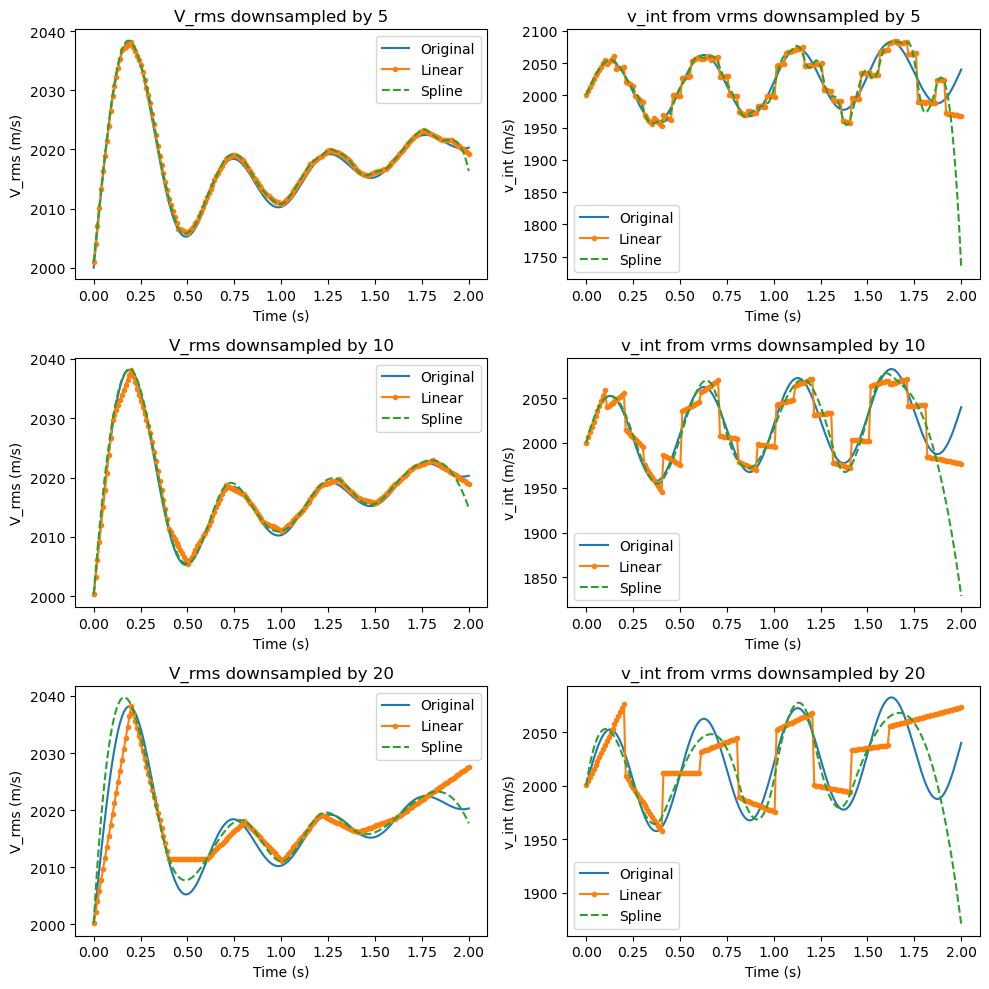

In [146]:
##compare three downsample levels and plot vint and vrms with cubic and linear interpolation
def downsample_and_interpolate(t, v0, alpha, beta, omega, factor):
    t_down = t[::factor]
    vrms_analytic_down = get_vrms(v0, alpha, beta, omega, t_down) + 1*np.random.rand(len(t_down))
    linear_interpolation = interp1d(t_down, vrms_analytic_down, kind="linear", fill_value="extrapolate")
    spline_interpolation = interp1d(t_down, vrms_analytic_down, kind="cubic", fill_value="extrapolate")
    vrms_down_linear = linear_interpolation(t)
    vrms_down_spline = spline_interpolation(t)
    vint_from_vrms_linear = get_vint_from_vrms(vrms_down_linear, t)
    vint_from_vrms_spline = get_vint_from_vrms(vrms_down_spline, t)
    return vrms_down_linear, vrms_down_spline, vint_from_vrms_linear, vint_from_vrms_spline
factors = [5, 10, 20]
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

for i, factor in enumerate(factors):
    vrms_down_linear, vrms_down_spline, vint_from_vrms_linear, vint_from_vrms_spline = downsample_and_interpolate(t, v0, alpha, beta, omega, factor)
    ax[i, 0].plot(t, vrms_analytic, label='Original')
    ax[i, 0].plot(t, vrms_down_linear,".-", label='Linear')
    ax[i, 0].plot(t, vrms_down_spline,"--", label='Spline')
    ax[i, 0].set_xlabel('Time (s)')
    ax[i, 0].set_ylabel('V_rms (m/s)')
    ax[i, 0].set_title(f'V_rms downsampled by {factor}')
    ax[i, 0].legend()

    ax[i, 1].plot(t, v_int, label='Original')
    ax[i, 1].plot(t, vint_from_vrms_linear,".-", label='Linear')
    ax[i, 1].plot(t, vint_from_vrms_spline,"--", label='Spline')
    ax[i, 1].set_xlabel('Time (s)')
    ax[i, 1].set_ylabel('v_int (m/s)')
    ax[i, 1].set_title(f'v_int from vrms downsampled by {factor}')
    ax[i, 1].legend()
    plt.tight_layout();

## Question 3 ##
Impacts of noise on data

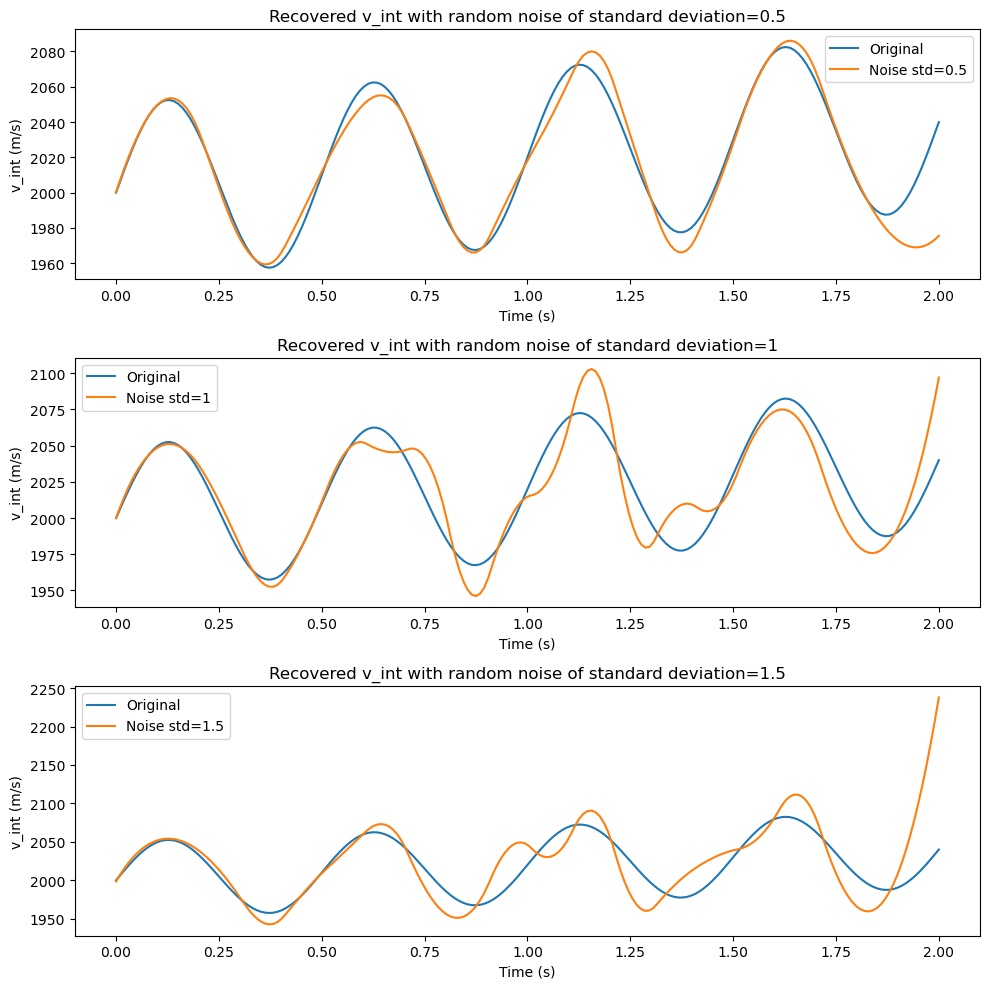

In [175]:
##part a
v0 = 2000
alpha = 50
beta = 20
omega = 2*np.pi*f
##Add noise to the interval velocity data using Gaussian random noise with std deviation 0.5,1,1.5
def downsample_gaussnoise_interpolate(t, v0, alpha, beta, omega, factor,std):
    vrms_analytic = get_vrms(v0,alpha,beta,omega,t)
    t_down = t[::factor]
    vrms_analytic_down = vrms_analytic[::factor]
    vrms_analytic_down += np.random.normal(0,std,len(vrms_analytic_down))   #add Gaussian noise
    linear_interpolation = interp1d(t_down, vrms_analytic_down, kind="linear", fill_value="extrapolate")
    spline_interpolation = interp1d(t_down, vrms_analytic_down, kind="cubic", fill_value="extrapolate")
    vrms_down_linear = linear_interpolation(t)
    vrms_down_spline = spline_interpolation(t)
    vint_from_vrms_linear = get_vint_from_vrms(vrms_down_linear, t)
    vint_from_vrms_spline = get_vint_from_vrms(vrms_down_spline, t)
    return vrms_down_linear, vrms_down_spline, vint_from_vrms_linear, vint_from_vrms_spline

#Plotting the results
stds = [0.5, 1, 1.5]
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
for i, std in enumerate(stds):
    vrms_down_linear_noise, vrms_down_spline_noise, vint_from_vrms_linear_noise, vint_from_vrms_spline_noise = \
        downsample_gaussnoise_interpolate(t, v0, alpha, beta, omega, 10,std)
    #v_int_noisy = add_noise(vint_from_vrms_spline, std)
    ax[i].plot(t,v_int , label='Original')
    ax[i].plot(t, vint_from_vrms_spline_noise, label=f'Noise std={std}')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('v_int (m/s)')
    ax[i].set_title(f'Recovered v_int with random noise of standard deviation={std}')
    ax[i].legend()
    plt.tight_layout();


Set $\alpha$ = 0, and explore different levels of
random noise. What happens if you add correlated noise (e.g. of the form $cos(\omega t)$)?
Include somefigures to show your results.

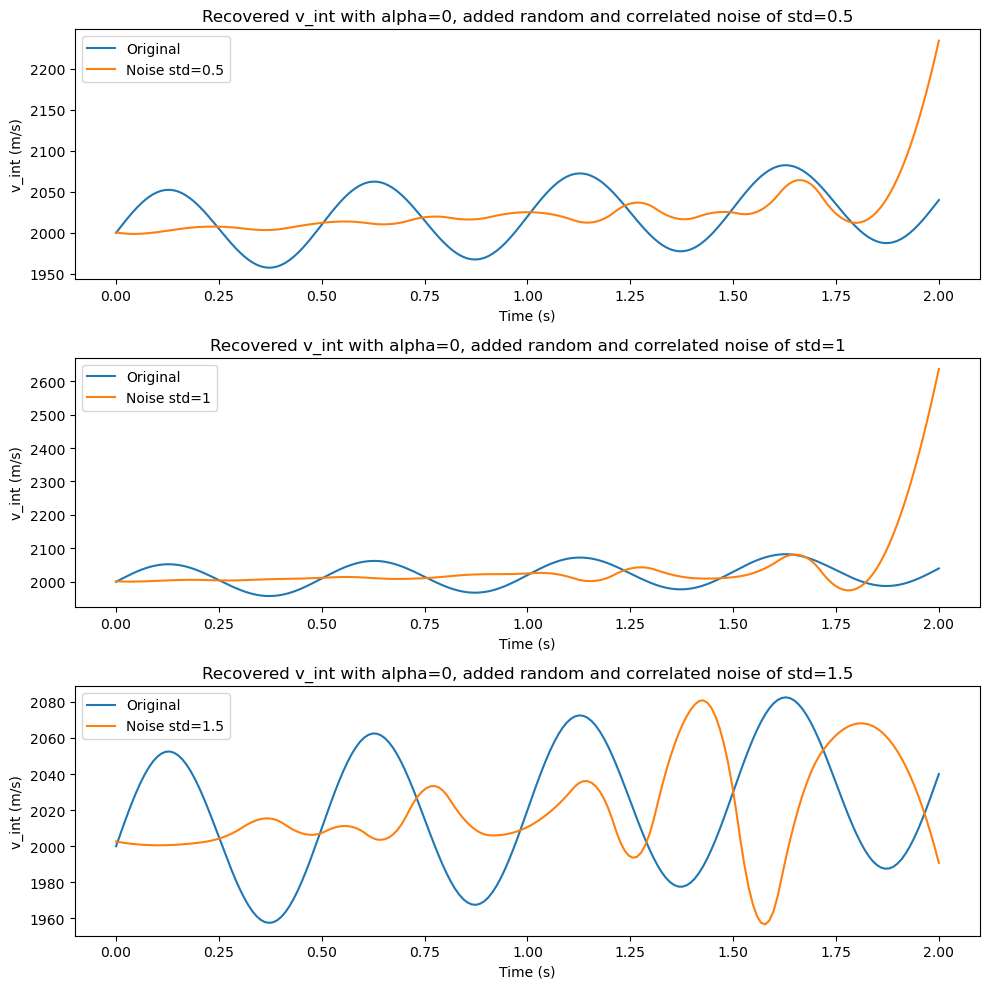

In [176]:
##part b
v0 = 2000
alpha = 0
beta = 20
omega = 2*np.pi*f

##Add noise to the interval velocity data using Gaussian random noise with std deviation 0.5,1,1.5

vrms_down_linear, vrms_down_spline, vint_from_vrms_linear, vint_from_vrms_spline = downsample_and_interpolate(t, v0, alpha, beta, omega, 10)
def downsample_corrnoise_interpolate(t, v0, alpha, beta, omega, factor,std):
    vrms_analytic = get_vrms(v0,alpha,beta,omega,t)
    t_down = t[::factor]
    vrms_analytic_down = vrms_analytic[::factor]
    vrms_analytic_down = vrms_analytic_down + np.cos(4*omega*t_down) # + np.random.normal(0,std,len(vrms_analytic_down))
    linear_interpolation = interp1d(t_down, vrms_analytic_down, kind="linear", fill_value="extrapolate")
    spline_interpolation = interp1d(t_down, vrms_analytic_down, kind="cubic", fill_value="extrapolate")
    vrms_down_linear = linear_interpolation(t)
    vrms_down_spline = spline_interpolation(t)
    vint_from_vrms_linear = get_vint_from_vrms(vrms_down_linear, t)
    vint_from_vrms_spline = get_vint_from_vrms(vrms_down_spline, t)
    return vrms_down_linear, vrms_down_spline, vint_from_vrms_linear, vint_from_vrms_spline

stds = [0.5, 1, 1.5]
#vrms_down_linear, vrms_down_spline, vint_from_vrms_linear, vint_from_vrms_spline = downsample_and_interpolate(t, v0, alpha, beta, omega, 10,stds)
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
for i, std in enumerate(stds):
    vrms_down_linear_noise, vrms_down_spline_noise, vint_from_vrms_linear_noise, vint_from_vrms_spline_noise = \
        downsample_gaussnoise_interpolate(t, v0, alpha, beta, omega, 10, std)
    ax[i].plot(t,v_int , label='Original')
    ax[i].plot(t, vint_from_vrms_spline_noise, label=f'Noise std={std}')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('v_int (m/s)')
    ax[i].set_title(f'Recovered v_int with alpha=0, added random and correlated noise of std={std}')
    ax[i].legend()
    plt.tight_layout();